In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

<h1> Rede Neural Multicamada </h1>
<div style="text-align:center"><img src="nn_arch.png" width="500" height="500"></div>

Para implementar esta rede precisaremos:<br> 
    <ol>
        <li>Estimar a saída com Feed Forward</li>
        <li>Calcular os erros e realizar a retropropagação</li>
        <li>Treino</li>
        <li>Teste</li>
    </ol>
    
    
<h2>Feed Forward</h2>
Neste modelo utilizaremos como função de ativação a <b>Sigmoid bipolar</b>: $ \sigma = \frac{2}{(1 + e^{-x})} - 1$ e erro $\sum \limits_{i = 0}^{n} \frac{1}{2}{(y - \hat{y})^{2}}$
<div style="text-align:center">
$$Z^{1} = \sum \limits_{i=0}^{n} {X}_{i} W_{i}^{1} + \beta_{1} = X \times W^{1}$$<br>
$$a^{1} = \sigma{ (Z^{1})}$$<br> 
$$Z^{2} = a^{1} \times W^{2}$$<br>
$$\hat{y} = \sigma{ (Z^{2})} $$
</div>
    
<h2>Retropropagation</h2>
Fazer a retropropagação basicamente significa não parar de calcular a regra da cadeia (de trás para frente), em suma buscaremos $\frac{\partial E} {\partial W} <0$ o que também será válido para $\rm I \!R $ superiores<br>Obs.: por fins visuais parcial (3) já estará multiplicada por (-1)<br><br>

$$\frac{\partial E} {\partial W^{2}} = \frac{\partial E} {\partial Z^{2}} \times \frac{\partial Z^{2}} {\partial W^{2}} \tag{1}$$<br>
$$\frac{\partial E} {\partial Z^{2}} = \frac{\partial E} {\partial \hat{y}} \times \frac{\partial \hat{y}} {\partial Z^{2}} \tag{2}$$<br>

sendo : 
$$\frac{\partial E} {\partial \hat{y}} = -(y - \hat{y})\tag{3}$$
$$\sigma^{'} = \sigma{(Z^{1})}(1 - \sigma{(Z^{2})})$$
$$\frac{\partial \hat{y}} {\partial Z^{2}} = \sigma^{'} = \sigma{(Z^{2})}(1 - \sigma{(Z^{2})}\tag{4}$$ <br>
$$\frac{\partial Z^{2}} {\partial W^{2}} = a^{1}\tag{5}$$<br>

Substituindo (3) e (4) em (2) temos:
$$\frac{\partial E} {\partial Z^{2}} = (y - \hat{y})\cdot \sigma^{'}(Z^2) = \delta^{2}\tag{6}$$<br>
logo: $$\frac{\partial E} {\partial W^{2}} = \mathbf{a^{1}}^\intercal \times \delta^{2}$$<br>

Partindo para a hidden layer<br>
$$\frac{\partial E} {\partial W^{1}} = \frac{\partial E} {\partial Z^{1}} \times \frac{\partial Z^{1}} {\partial W^{1}} \tag{7}$$<br>
$$\frac{\partial E} {\partial Z^{1}} = \frac{\partial E} {\partial a^{1}} \times \frac{\partial a^{1}} {\partial Z^{1}} \tag{8}$$<br>
$$\frac{\partial E} {\partial a^{1}} = \frac{\partial E} {\partial Z^{2}} \times \frac{\partial Z^{2}} {\partial a^{1}} \tag{9}$$<br>

sendo: 
$$\frac{\partial Z^{2}} {\partial a^{1}} = \frac {\sum \limits_{i=0}^{n} a_{i}^{1}W_{i}^{2} + \beta_{2}} {\partial a^{1}} = W^{2} \tag{10}$$<br>
$$\frac{\partial a^{1}} {\partial Z^{1}} = \sigma^{'}(Z^1)\tag{11}$$ <br>
$$\frac{\partial Z^{1}} {\partial W^{1}} = X \tag{12}$$<br>

Substituindo (6) e (10) em (9) temos:
$$\frac{\partial E} {\partial a^{1}} = \mathbf{W^{2}}^\intercal \times \delta^{2} \tag{13}$$<br>
com (13) e (11) em (8) temos: 
$$\frac{\partial E} {\partial Z^{1}} = \mathbf{W^{2}}^\intercal \times \delta^{2} \cdot \sigma^{'}(Z^1) = \delta^{1} \tag{14}$$<br>
logo (14) e (12) em (7) temos:
logo: $$\frac{\partial E} {\partial W^{1}} = \mathbf{X}^\intercal \times \delta^{1}$$<br>
</div>

<h2> Atualizando os pesos</h2>
    $$W2 = W2 + \frac{\partial E} {\partial W^{2}} \alpha$$<br>
    $$\beta_{2} = \beta_{2} \delta^{2} \alpha$$<br>
    $$W1 = (W1 + \frac{\partial E} {\partial W^{1}}) \alpha$$<br>
    $$\beta_{1} = (\beta_{2} \delta^{1})\alpha$$




In [8]:
#X*W1 -> Z1 -> sigmoid(Z1)-> a1 -> a1*W2 -> Z2 -> sigmoid(Z2) -> Yhat 
class NeuralNetwork:
    def __init__(self, input_values, output, hidden_size, alfa = 0.02, epochs = 1000):
        self.X = input_values
        self.output = output
        self.hidden = hidden_size
        self.alfa = alfa
        self.erro = 0.001
        self.epochs = epochs
        self.m = self.X.shape[1]
        
        #Pesos hidden layer
        self.w1 = np.random.rand(self.X.shape[1], self.hidden) - 0.5
        self.bw1 = np.random.rand(1, self.hidden) - 0.5

        self.delta_inv = np.zeros((self.hidden, 1))
        self.delta1 = np.zeros((self.hidden, 1))

        #Pesos camada de saída
        self.w2 = np.random.rand(self.hidden, self.output.shape[1]) - 0.5
        self.bw2 = np.random.rand(self.output.shape[1], 1) - 0.5
    
        self.delta2 = np.zeros((self.output.shape[1], 1))

    def sigmoid_bipolar(self, z):
        return (2/(1+np.exp(-z))) - 1
    
    def sigmoid_partial(self, z2):
        return (0.5 *(1 + z2)*(1 - z2))
    
    def feed_forward(self, X):
       
        #Propagando entrada pela rede:
        
        self.z1 =  np.dot(X, self.w1) + self.bw1 #Xw + b
        self.a1 =  self.sigmoid_bipolar(self.z1)  #z = f(zin)
        
        #Cálculo saída da rede
        
        self.z2 = np.dot(self.a1, self.w2) + self.bw2 #y_in = ZW + Bw 
        self.yhat = self.sigmoid_bipolar(self.z2) #yhat = f(z_in)
        return self.yhat
    
    
    def retropropagation(self):
        
        #Não parar de calcular a regra da cadeia
        #Cálculo erro da camada de saída (Calculo deltinha_out)
        
        self.dyhat = (self.output - self.yhat) #dE/dYhat
        self.delta2 = self.dyhat * self.sigmoid_partial(self.yhat) #dE/dZ2 = dE/dYhat * dYat/dZ2
        
        #Cálculo delta das hidden layers (Cálculo deltinha_in)
        
        self.da1 = self.delta2.dot(self.w2.T) #dE/da1 = dE/dZ2 * dZ2/da1
        self.delta1 = self.da1 * self.sigmoid_partial(self.a1) #dE/dZ1 = dE/da1 * da1/dZ1
        
        #Delta dos pesos do output layer
        
        self.dEdW2 = self.alfa * (self.a1.T.dot(self.delta2)) #dE/dW2 = dE/dZ2 * dZ2/dW2 (a1)
        self.dEdBw2 = np.sum(self.alfa * self.delta2, axis = 0)
    
        
        #Delta pesos da hiden layer
        
        self.dEdW1 = self.alfa * (self.X.T.dot(self.delta1)) #dE/dW1 = dE/dZ1 * dZ1/dW1 (X)
        self.dEdBw1 = np.sum(self.alfa * self.delta1, axis=0)
        
        #Pesos camada de saída
        
        self.w2 += self.dEdW2
        self.bw2 += self.dEdBw2
        
        #Pesos hidden layer
        
        self.w1 += self.dEdW1
        self.bw1 += self.dEdBw1
        
    def train(self):
        epoch = 0 
        self.lsm = []
        erro_total = 1
        self.acc_va = []
        self.acc_va.append(1)
        while(epoch < self.epochs) or (erro_total < self.erro):
            erro_total = 0
            yhat = self.feed_forward(self.X)
            self.retropropagation()
            
            erro_total += sum(0.5*((self.output - yhat)**2)) #Cálculo erro
            self.lsm.append(erro_total)
                
            epoch +=1
        
        tam = len(self.lsm)
        X_grid = np.array(np.arange(0, tam))
        plt.scatter(X_grid, self.lsm)
        plt.show()
        
    def predict(self, X):
       
        #Propagando entrada pela rede
            
        z1 =  np.dot(X, self.w1) + self.bw1 #z1 = XW1 + b
        a1 =  self.sigmoid_bipolar(z1)  #a1 = sigmoid(z1)
        
        #Cálculo saída da rede
        
        z2 = np.dot(a1, self.w2) + self.bw2 #z2 = ZW2 + Bw 
        yhat = self.sigmoid_bipolar(z2) #yhat = sigmoid(z2)
        return yhat

<h3> Treino da Rede</h3>

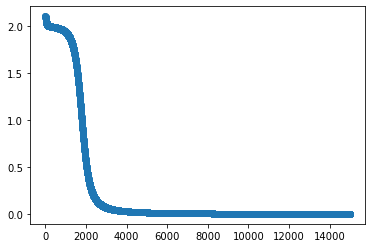

In [3]:
X = np.array([[1, 1, 1, -1, -1, 1, -1, -1]]).reshape(4,2)
y = np.array([[-1, 1, 1 ,-1]]).reshape(4,1)

nn = NeuralNetwork(X, y, 4, 0.01, 15000)
nn.train()

<h3> Função de ativação</h3>

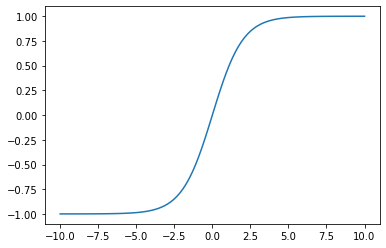

In [4]:
x_grid = np.linspace(-10, 10, 100)
plt.plot(x_grid, nn.sigmoid_bipolar(x_grid))
plt.show()

In [5]:
y_pred = nn.predict(X)
y_pred

array([[-0.95856122],
       [ 0.95718365],
       [ 0.96167455],
       [-0.9601004 ]])

In [6]:
nn.w1

array([[-2.2392299 , -1.87239852,  1.84858483,  2.17050212],
       [ 2.1816368 , -2.07306407, -1.91980693,  1.98592832]])

In [7]:
nn.w2

array([[3.13650695],
       [2.89615061],
       [2.85998344],
       [2.9926151 ]])